# Introduction to NLP Fundamentals in Tensorflow


In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a9e976ab-ae7f-81e5-9428-73dbdc61c7c9)


# Get text dataset

The dataset we are going to be using is Kaggle Introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

Original source: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-08-19 14:49:52--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-08-19 14:49:53 (148 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Unzip the data
unzip_data("/content/nlp_getting_started.zip")

## Visualizing a text dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does test_df looks like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class are tehre
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher total samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring

---

Target: 1 (real disaster)
Text:
Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06

---

Target: 0 (not real disaster)
Text:
Element of Freedom: The Biggest Party of the Summer @ Mirage Saturday! Tickets at http://t.co/7hAnPcr5rK

---

Target: 0 (not real disaster)
Text:
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/lFW4KUukeM http://t.co/k3mnk9HnZ5

---

Target: 0 (not real disaster)
Text:
And the fact that i have a curfew

---



### Split data into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# use train_test_split to split training data into validation_data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# check len
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you build a model is to convert text into numbers.

There are few ways to do this, namely:
* Tokenization: direct mapping of token (a token could be word or a character) to number
* Embedding: create a mtrix of feature vector for each token (the size of feature vector can be defined and this embedding can be learned)

## Text vectorization (Tokenization)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# # use default TextVectorization paramaters
# text_vectorizer = TextVectorization(max_tokens=None, # define how many words in the vocabulory (automatically add <OOV>)
#                                     standardize="lower_and_strip_punctuation",
#                                     split="whitespace",
#                                     ngrams=None, # create groups of n words
#                                     output_mode="int", # How map tokens to numbers
#                                     output_sequence_length=None, # how long do you want your sequences to be
#                                     pad_to_max_tokens=True
#                                     )

In [ ]:
# Find average number of tokens (words) in training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulory
max_length = 15 # max length of our sequences would be (eg how many words from tweet our models see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = " There's a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")

text_vectorizer([random_sentence])

Original text:
 Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by SÛ_ http://t.co/0XCb7yeqmw        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1275,  494, 4567, 2789, 2809,   26,   15, 2556, 1248, 1141,    5,
         144, 3694,   60, 2690]])>

In [ ]:
# get the unique words in vocabulory
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [ ]:
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding we are going to use TensorFlow embedding's layer

The parameters we care most about our embedding layer:
* `input_dim` = size of our vocabulory
* `output_dim` = the size of output embedding vector, for example, a value of 100  would mean token get represented by vector 100 long
* `input_length` = length of sequences passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Officials: Alabama home quarantined over possible Ebola case http://t.co/UYUgFg3k1h        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00315282,  0.03637792, -0.01971934, ..., -0.04903173,
          0.00115634,  0.01357133],
        [ 0.01391032, -0.02363701,  0.04624157, ...,  0.04407731,
         -0.02907783, -0.03929185],
        [ 0.00454717, -0.01295703, -0.00409172, ...,  0.00670707,
          0.00589393, -0.04865455],
        ...,
        [-0.00771252, -0.00467433, -0.03614527, ...,  0.03763732,
          0.01181948,  0.01504785],
        [-0.00771252, -0.00467433, -0.03614527, ...,  0.03763732,
          0.01181948,  0.01504785],
        [-0.00771252, -0.00467433, -0.03614527, ...,  0.03763732,
          0.01181948,  0.01504785]]], dtype=float32)>

In [ ]:
# Check out single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00315282,  0.03637792, -0.01971934,  0.03175657,  0.03309642,
        -0.03294275,  0.03924571,  0.02013606,  0.03161471, -0.03758777,
        -0.00323486, -0.01300901,  0.01001105,  0.02413725, -0.02048036,
         0.00289533,  0.02173892,  0.01766847,  0.0455437 ,  0.02720292,
        -0.02097536, -0.03184055, -0.03294554,  0.00646553,  0.02927028,
        -0.03136405, -0.04422004, -0.04710921,  0.04855782,  0.02132935,
         0.02672884,  0.0160542 , -0.03062043,  0.00481199, -0.00590439,
         0.02729565,  0.0154666 , -0.00193818,  0.04966897,  0.02625104,
         0.03412301, -0.04513419, -0.02728072, -0.04723741,  0.01816132,
        -0.02713267, -0.02630262, -0.03373674, -0.0218274 ,  0.00189825,
        -0.0366145 , -0.02622653, -0.04881812,  0.02085834,  0.03742203,
        -0.00431839,  0.04031469, -0.01690692, -0.00561547,  0.04993269,
         0.04869283,  0.03741861, -0.04607017, -0.02418159, -0.02594949,
  

## Modelling a text dataset (running a series of experiment)

Now we've got way to turn our text sequence into numbers, it's time to start series of modelling experiments

* Model 0: Naive Bayes (baseline), this is from Sklearn ml map : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed forward neural network
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolution Neural network (CNN)
* Model 6: TensorFlow Hub pretrained feature extractor (using Transfer learning for NLP)
* Model 7: Same as model 6 with 10% training data

How are we going to approach it?

Steps:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with machine learning experiments it's important to create a baseline model as benchmark

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the Scikit-Learn machine learning map.

> **Note**: It's common practice to use a non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                      ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                      ("clf", MultinomialNB()) # model our text
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

In [ ]:
print(f"Baseline model accuracy: {baseline_score*100:.2f}%")

Baseline model accuracy: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating a evaluation function for our modelling experiments

We could have model's predictions with different metrics every time, however this will be cumbersome and could easily be fixed with function

Let's create one to compare model's prediction with truth labels using following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1score using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [ ]:
# Create a tensorborad callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # Turn the input text into numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210819-145127
Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.6083 - accuracy: 0.6965 - val_loss: 0.5362 - val_accuracy: 0.7415
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4407 - accuracy: 0.8199 - val_loss: 0.4747 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3465 - accuracy: 0.8634 - val_loss: 0.4536 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2840 - accuracy: 0.8908 - val_loss: 0.4631 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2369 - accuracy: 0.9129 - val_loss: 0.4821 - val_accuracy: 0.7848


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7848


[0.482132226228714, 0.7847769260406494]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [ ]:
model_1_pred_probs[:10]

array([[0.29385406],
       [0.75379765],
       [0.9981006 ],
       [0.11186773],
       [0.09858007],
       [0.9443674 ],
       [0.91299766],
       [0.9933941 ],
       [0.96458966],
       [0.27200913]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.7811320906944167,
 'precision': 0.7914526971511877,
 'recall': 0.7847769028871391}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulory from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in out training data which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)  # same as vocab  size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it

To do sp, TensorFlow has a handy tool called projector : https://projector.tensorflow.org/

And also guide on word embedding:

In [ ]:
# Create embedding files (we've got this frm Tensorflow word embeddings documentation)
# import io
#out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
#out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

#for index, word in enumerate(words_in_vocab):
 # if index == 0:
   # continue  # skip 0, it's padding.
 # vec = embed_weights[index]
 # out_v.write('\t'.join([str(x) for x in vec]) + "\n")
 # out_m.write(word + "\n")
#out_v.close()
#out_m.close()

In [ ]:
# Download files from Colab to upload to projector
#try:
  #from google.colab import files
  #files.download('vectors.tsv')
  #files.download('metadata.tsv')
#except Exception:
 # pass

> Note: Check out Jay Alammar's word2vec post

## Recurrent Neural Networks (RNN)

RNN' useful for sequence data

The premise of RNN is to use the representation of previous input to aid the representation of a later input


### Model 2: LSTM

LSTM = long Short Term Memory (one of the most popular LSTM cells)

Our strructure of RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/dense) -> Ouput (label probability)
```

In [ ]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210819-145139
Epoch 1/5
215/215 [==============================] - 7s 11ms/step - loss: 0.2260 - accuracy: 0.9190 - val_loss: 0.6603 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1580 - accuracy: 0.9413 - val_loss: 0.6118 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1270 - accuracy: 0.9523 - val_loss: 0.8198 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1061 - accuracy: 0.9622 - val_loss: 0.6973 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0937 - accuracy: 0.9660 - val_loss: 0.8804 - val_accuracy: 0.7703


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[3.0188009e-02],
        [8.8271356e-01],
        [9.9974245e-01],
        [4.3458581e-02],
        [6.5241044e-04],
        [9.9719965e-01],
        [8.8119787e-01],
        [9.9980766e-01],
        [9.9968338e-01],
        [6.8411165e-01]], dtype=float32))

In [ ]:
# Convert model 2 probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'f1': 0.7694283709964855,
 'precision': 0.7701965974536404,
 'recall': 0.7703412073490814}

### Model 3: GRU

Another popular and effective RNN component is GRU or gated recurrent unit.

The GRU cell has similiar features to an LSTM cell but has less parameters

In [ ]:
# Build an RNN using GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.GRU(64, return_sequences=True)(x) # If you need to stack recurrent layers on the top of each other, you need return_sequences=True
#x = layers.LSTM(64)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210819-145202
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.1581 - accuracy: 0.9367 - val_loss: 0.6997 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0834 - accuracy: 0.9692 - val_loss: 0.9427 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0699 - accuracy: 0.9731 - val_loss: 0.9295 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0660 - accuracy: 0.9736 - val_loss: 0.9572 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9781 - val_loss: 1.1096 - val_accuracy: 0.7782


In [ ]:
# Make some predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.05083222e-03],
       [9.41429317e-01],
       [9.99784529e-01],
       [7.30372146e-02],
       [1.01576166e-04],
       [9.99473393e-01],
       [7.46154308e-01],
       [9.99915123e-01],
       [9.99851704e-01],
       [9.28586066e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7763875633348853,
 'precision': 0.7796479981380524,
 'recall': 0.7782152230971129}

### Model 4: Bidirectional RNN

Normal RNN go from left to right however bidirectional RNN goes from right to left as well as left to right


In [ ]:
# Build a bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # If you need to stack recurrent layers on the top of each other, you need return_sequences=True

outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")


In [ ]:
# Model summary
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Bidirectional")])

Saving TensorBoard log files to: model_logs/Bidirectional/20210819-145212
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.1027 - accuracy: 0.9715 - val_loss: 1.0647 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0524 - accuracy: 0.9788 - val_loss: 1.0330 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0468 - accuracy: 0.9800 - val_loss: 1.3715 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0475 - accuracy: 0.9801 - val_loss: 1.4122 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0411 - accuracy: 0.9819 - val_loss: 1.2659 - val_accuracy: 0.7625


In [ ]:
# Make some predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[6.4382465e-03],
       [6.8000668e-01],
       [9.9990952e-01],
       [1.6228098e-01],
       [7.0795584e-05],
       [9.9711549e-01],
       [3.1507224e-01],
       [9.9997091e-01],
       [9.9995327e-01],
       [9.9107051e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'f1': 0.7609952154742672,
 'precision': 0.7628028463824278,
 'recall': 0.7624671916010499}

## Convolution Neural Networks for Text (and other types of sequences)

Here text data is 1D, unlike the Conv2D for images

The typical structure for Conv1D model for the sequences (in out case, text):

```
Inputs(text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Ouputs (class probabilities)


### Model 5: Conv1D

In [ ]:
# Test our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["This is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # looks 5 words at a time
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test) # Pass test embedding through conv
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important feature

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.07725899, -0.00208617,  0.01275189, ...,  0.04161704,
         -0.06714877,  0.03499146],
        [-0.01904166,  0.00544956,  0.00141586, ...,  0.01907289,
         -0.04917812,  0.04855959],
        [-0.03216459, -0.03571119,  0.03529596, ...,  0.07050278,
         -0.03342109,  0.00516381],
        ...,
        [-0.01870003,  0.00282878, -0.01714854, ...,  0.03047674,
         -0.01698542,  0.03576649],
        [-0.01870003,  0.00282878, -0.01714854, ...,  0.03047674,
         -0.01698542,  0.03576649],
        [-0.01870003,  0.00282878, -0.01714854, ...,  0.03047674,
         -0.01698542,  0.03576649]]], dtype=float32)>

In [ ]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.00229936, 0.04345039, 0.02494564, 0.09108376,
         0.        , 0.        , 0.        , 0.02324758, 0.04570533,
         0.01253909, 0.00815487, 0.01656542, 0.04578978, 0.02833251,
         0.        , 0.        , 0.01609664, 0.00619181, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00904534, 0.02160474, 0.        , 0.        , 0.        ,
         0.        , 0.03360397],
        [0.03250078, 0.        , 0.04206443, 0.03854398, 0.03586268,
         0.0168672 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.0466136 ,
         0.        , 0.06614183, 0.        , 0.        , 0.        ,
         0.01051596, 0.00058154, 0.05222114, 0.00374603, 0.        ,
         0.00979178, 0.        , 0.        , 0.02708707, 0.03214677,
         0.01649703, 0.        ],
        [0.03940763, 0.        , 0.        , 0.0310

In [ ]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03940763, 0.00229936, 0.04868884, 0.03854398, 0.09108376,
        0.03453527, 0.01173131, 0.06187479, 0.02957511, 0.08648816,
        0.0590044 , 0.04103464, 0.03424337, 0.04578978, 0.0466136 ,
        0.03877335, 0.06614183, 0.01609664, 0.00619181, 0.02131452,
        0.06294878, 0.03115488, 0.05222114, 0.00374603, 0.01457842,
        0.00979178, 0.02762724, 0.06761575, 0.03271902, 0.03214677,
        0.05865832, 0.05370044]], dtype=float32)>

In [ ]:
# Create Conv1D layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", strides=1, padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get model 5 summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels, epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210819-145250
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.1192 - accuracy: 0.9612 - val_loss: 0.9562 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0760 - accuracy: 0.9715 - val_loss: 1.0286 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0603 - accuracy: 0.9762 - val_loss: 1.1838 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0559 - accuracy: 0.9787 - val_loss: 1.2390 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0497 - accuracy: 0.9796 - val_loss: 1.2832 - val_accuracy: 0.7520


In [ ]:
# Make some predictions with our conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.1166660e-02],
       [8.0003905e-01],
       [9.9987125e-01],
       [4.4586767e-02],
       [1.2977739e-08],
       [9.7885531e-01],
       [8.2011300e-01],
       [9.9992955e-01],
       [9.9999595e-01],
       [8.0425733e-01]], dtype=float32)

In [ ]:
# Convert pred to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate
model_5_results = calculate_results(val_labels, model_5_preds)

In [ ]:
model_5_results

{'accuracy': 75.19685039370079,
 'f1': 0.7497885511234939,
 'precision': 0.7529888699847289,
 'recall': 0.7519685039370079}

## Model6: Tensorflow Hub pretrained Sentence encoder

Universal samples encoder

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you can the unviresal encoder on sentence, it turns into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [ ]:
# Create a Keras Layer using USE pretrained layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
      sentence_encoder_layer,
      layers.Dense(64, activation="relu"),
      layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [ ]:
# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#  Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210819-145321
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.5048 - accuracy: 0.7863 - val_loss: 0.4459 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4150 - accuracy: 0.8154 - val_loss: 0.4368 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4007 - accuracy: 0.8215 - val_loss: 0.4346 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3926 - accuracy: 0.8241 - val_loss: 0.4296 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3856 - accuracy: 0.8314 - val_loss: 0.4391 - val_accuracy: 0.8058


In [ ]:
# Make some predictions with our conv1D model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.1275312 ],
       [0.75556064],
       [0.9890659 ],
       [0.18554153],
       [0.64724714],
       [0.68922263],
       [0.9757361 ],
       [0.9724954 ],
       [0.9378454 ],
       [0.07190886]], dtype=float32)

In [ ]:
# Convert pred to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.5774278215223,
 'f1': 0.8027699557689516,
 'precision': 0.812489180208857,
 'recall': 0.8057742782152231}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub Pretrained but with 10% training data

Transfer learning helps when you don't have a large dataset

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained o 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head()
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()


> **Note**:  be very careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation might be wrong. If something looks too good to be true ( a model trained on 10% of data outperforming the same model trained on 100% of data)
Go back find erroe!

In [ ]:
# Making a better dataset split , no data leakage
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the no of each label in updated train data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Check number of tragets in our subsets of data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model same as to model you created you can use `tf.keras.models.clone_model()` method, see more:

In [ ]:
# Create a same model as model 6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
      sentence_encoder_layer,
      layers.Dense(64, activation="relu"),
      layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get summary same as model 6
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% training data subset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210819-145338
Epoch 1/5
22/22 [==============================] - 3s 86ms/step - loss: 0.6730 - accuracy: 0.6613 - val_loss: 0.6512 - val_accuracy: 0.7441
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.6058 - accuracy: 0.8073 - val_loss: 0.5934 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5307 - accuracy: 0.8073 - val_loss: 0.5397 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4698 - accuracy: 0.8190 - val_loss: 0.5071 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4267 - accuracy: 0.8248 - val_loss: 0.4906 - val_accuracy: 0.7743


In [ ]:
# Make some predictions with our conv1D model
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.22573267],
       [0.59722126],
       [0.8973773 ],
       [0.35136148],
       [0.5060503 ],
       [0.6980224 ],
       [0.88337344],
       [0.8085527 ],
       [0.84563494],
       [0.17112951]], dtype=float32)

In [ ]:
# Convert pred to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'f1': 0.7723566516531356,
 'precision': 0.7757380419380466,
 'recall': 0.7742782152230971}

In [ ]:
print("Hi")

Hi


# Compare the performance of each of our models

In [ ]:
# Combine model results into dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_Simple Dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1D": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [ ]:
# reduce accuraacy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100

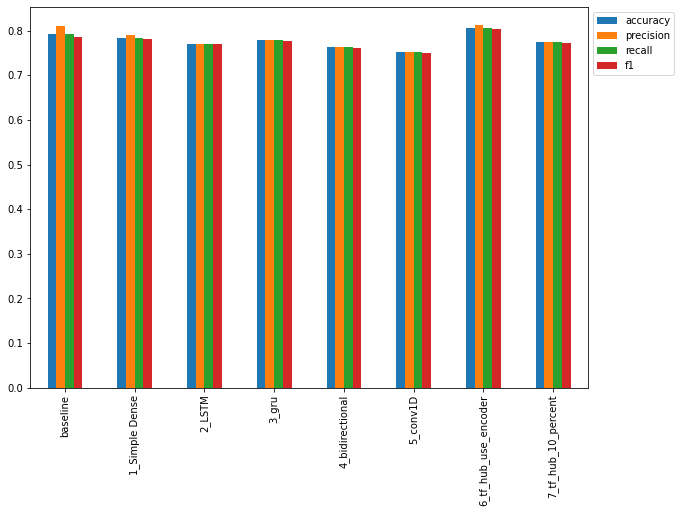

In [ ]:
# Plot and compare the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

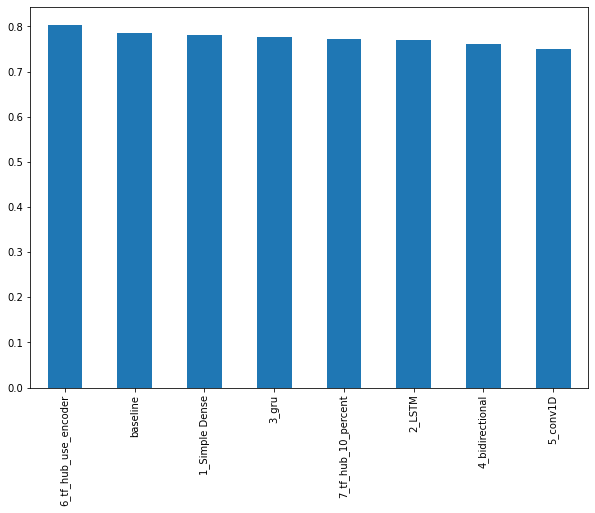

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Uploading our model training logs to TensorBoard Dev

In [ ]:
# View tensorboard logs
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architectures on the Kaggle tweet classification dataset" \
  --one_shot

In [ ]:
# See previous TensorBoard Dev experiment
!tensorboard dev list

2021-08-19 15:55:34.112168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 15:55:34.120350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 15:55:34.120859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/zTK8zeoFRSmPkaWEzNV62A/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle tweet classification dataset
	Id                   zTK8zeoFRSmPkaWEzNV62A
	Created              2021-08-19 15:43:16 (12 minutes ago)
	Updat

In [ ]:
# !tensorboard dev delete --experiment_id zTK8zeoFRSmPkaWEzNV62A

## Saving and loading trained model

Two ways
1. HDF5 format
2. `SavedModel` format (this si default when using tensorflow)

In [ ]:
# Save Model 6 to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load the model
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4391 - accuracy: 0.8058


[0.43914034962654114, 0.8057742714881897]

Now save to `SavedModel` format

In [ ]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [ ]:
# Load a model in SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4391 - accuracy: 0.8058


[0.43914034962654114, 0.8057742714881897]

## Finding the most wrong examples



In [ ]:
# Download pretrained data
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
unzip_data("08_model_6_USE_feature_extractor.zip")

--2021-08-19 16:15:48--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   244MB/s    in 3.8s    

2021-08-19 16:15:52 (243 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [ ]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
# Make prediction with loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create a dataframe with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})

In [ ]:
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [ ]:
# Fine thw rong prediction and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong.head() # False postive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


0: Not disaster
1: disaster

In [ ]:
most_wrong.tail() # Flase negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Check the false positives (model predicted 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"text:\n{text}\n")
  print("-----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!


In [ ]:
# Check the false negatives (model predicted 1 when should have been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"text:\n{text}\n")
  print("-----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
text:
@DavidVonderhaar At least you were sincere ??

-----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred: 0.0, Prob: 0.05460336431860924
text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred: 0.0, Prob: 0.05459698289632797
text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, Pr

## Making predictions on the test dataset

In [ ]:
# Making prediction on test and visualising them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"test:\n{test_sample}\n")
  print("-----\n")

Pred: 0, Prob: 0.10977931320667267
test:
@frailnerves I SCREAMED

-----

Pred: 0, Prob: 0.4540296494960785
test:
Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-0992 http://t.co/tk9HnxZNSl http://t.co/UhBUwbeQ0O

-----

Pred: 1, Prob: 0.9748289585113525
test:
Top story: MH370: Reunion debris is from missing plane - BBC News http://t.co/jasWg2MwIi see more http://t.co/qgk64YPN13

-----

Pred: 1, Prob: 0.8150160312652588
test:
Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT.; Francis Joseph's Crack Regiment Annihilated on Carso Plateau.
http://t.co/D1sPSwl66H

-----

Pred: 0, Prob: 0.06859749555587769
test:
WHAT A DISASTER FOR SECRET  #TI5

-----

Pred: 0, Prob: 0.06922597438097
test:
[VID]150806 Luhan From Luhan Studio Channel on YOUKU Update 

http://t.co/W7yeZkQlCJ http://t.co/C0QWZ0IshR

-----

Pred: 1, Prob: 0.9510711431503296
test:
RT @LivingSafely: NWS posts Severe #Thunderstorm Warnings for parts of #AR #NC #OK. Seek strong shelter if at risk: http://t.co/kImr0l24Fb

-----

Pred: 0

## The speed/score tradeoff

In [ ]:
# Let's make function to measure time of prediction
import time
def pred_timer(model, samples):
  """
  Time how long a model taeks to make prediction on samples
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get end time
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                     samples = val_sentences)

model_6_total_pred_time, model_6_time_per_pred

(0.2281487370000832, 0.00029940779133869186)

In [ ]:
# Calculate TF Hub Sentence encoder time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                     samples = val_sentences)

baseline_total_pred_time, baseline_time_per_pred

(0.018323705000511836, 2.404685695605228e-05)

In [ ]:
model_6_pretrained_results = calculate_results(val_labels,
                                               model_6_pretrained_preds)

model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

Text(0, 0.5, 'F1-Score')

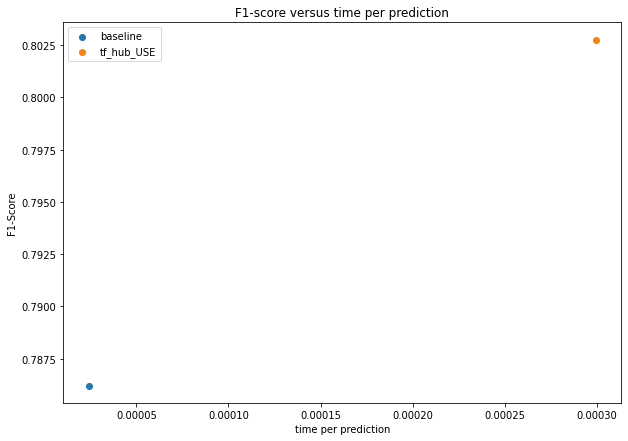

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_USE")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("time per prediction")
plt.ylabel("F1-Score")